# LADMPSAP

### By ZincCat

$$\min _{\mathbf{Z}, \mathbf{E}}\|\mathbf{Z}\|_{*}+\lambda\|\mathbf{E}\|_{2,1}$$

$$\text{s.t. }\mathbf{D}=\mathbf{D Z}+\mathbf{E}, \mathbf{Z}^{T} \mathbf{1}=\mathbf{1}, \mathbf{Z}\geqslant \mathbf{0} $$

In [176]:
import numpy as np
from matplotlib import pyplot as plt
from time import time
from sklearn.decomposition import TruncatedSVD
from sklearn.utils.extmath import randomized_svd
%matplotlib inline

In [177]:
p = 200
n = 300
np.random.seed(19890817)
D = np.random.normal(0, 1, (p, n))

In [178]:
def norm21(X):
    return np.linalg.norm(np.linalg.norm(X, 2, axis=0), 1)

def f(Z, E, lam):
    return np.linalg.norm(Z, 'nuc') + lam * norm21(E)

# l2,1-norm shrinkage operator
def H(M, eps):
    norm = np.linalg.norm(M, 2, axis=0)
    M[:, norm>eps] *= (norm[norm>eps] - eps)/norm[norm>eps]
    M[:, norm<=eps] = 0
    return M


# soft shrinkage operator
def S(x, eps):
    x[np.abs(x) < eps] = 0
    x[x >= eps] -= eps
    x[x <= -eps] += eps
    return x

In [179]:
def update_E(Z, L, lam, beta):
    M = D - D@Z + L/beta
    # M = M[0:-1]
    Enew = H(M, lam/beta)
    # Enew = np.vstack((Enew, np.zeros(n)))
    return Enew

def update_Z(Z, E, L, Y, M, l, beta, etaZ, r, n):
    N = D + L/beta - E
    W = Z - (D.T@(D@Z-N) + np.sum(l)/beta + np.sum(Z, axis=0)/beta-np.ones((1, n)))/etaZ + Y/etaZ - M/beta/etaZ
    U, sigma, V = np.linalg.svd(W)
    # U, sigma, V = randomized_svd(W, n_components=r)
    sigma = S(sigma, 1/beta/etaZ)
    # if count < r:
    #     r = min(n, count+1)
    # else:
    #     r = min(n, r + int(0.05*n))
    Znew = U@np.diag(sigma)@V
    return Znew

def update_beta(beta, maxBeta, rho0, eta, eps2, dE, dZ, dY, normD):
    satisfied = False
    if beta*np.max((np.sqrt(3.1)*dE, np.sqrt(eta)*dZ, np.sqrt(3.1)*dY))/normD < eps2:
        rho = rho0
        satisfied = True
    else:
        rho = 1
    return min(beta*rho, maxBeta), satisfied

In [193]:
beta = 1e-4
maxBeta = 1e4
maxIter = 100000
eps1 = 1e-2
eps2 = 1e-2
rho0 = 1.9
lam = 0.01

In [194]:
def LADMPSAP(f, Din, lam, beta, maxBeta, maxIter, rho0, eps1, eps2, r, log, logbeta):
    step = 0
    D = Din.copy()
    p, n= D.shape
    E = np.zeros((p, n))
    Z = np.zeros((n, n))
    L = np.zeros((p, n))
    Y = np.zeros((n, n))
    M = np.zeros((n, n))
    l = np.zeros(n)
    dL = D - D@Z - E
    dLnorm = np.linalg.norm(dL)
    normD = np.linalg.norm(D)
    dM = Z - Y
    dMnorm = np.linalg.norm(dM)
    etaZ = normD**2*3.1
    crit1 = False
    crit2 = False
    while step < maxIter:
        if step % 1 == 0:
            value = f(Z, E, lam)
            print(step, value, 'gap', dLnorm, dMnorm, beta, crit1, crit2)
            log.append(value)
        logbeta.append(beta)
        Enew = update_E(Z, L, lam, beta)
        Znew = update_Z(Z, E, L, Y, M, l, beta, etaZ, r, n)
        Ynew = np.maximum(Z, 0)
        dE = np.linalg.norm(Enew-E)
        dZ = np.linalg.norm(Znew-Z)
        dY = np.linalg.norm(Ynew-Y)
        E = Enew
        Z = Znew
        Y = Ynew
        dl = np.sum(Z, axis=0) - np.ones((1, n))
        dL = -D@Z - E + D
        dLnorm = np.linalg.norm(dL)
        dM = Z - Y
        dMnorm = np.linalg.norm(dM)
        L = L + beta * dL
        l = l + beta * dl
        M = M + beta * dM
        crit1 = dLnorm/normD < eps1
        beta, crit2 = update_beta(
            beta, maxBeta, rho0, etaZ, eps2, dE, dZ, dY, normD)
        if crit1 and crit2:
            print("Converged at step", step)
            value = f(Z, E, lam)
            print(step, value, 'gap', dLnorm, dMnorm)
            break
        step += 1
    return Z, E, L

In [195]:
log = []
logbeta = []
Z, E, L = LADMPSAP(f, D, lam, beta, maxBeta, maxIter, rho0, eps1, eps2, r, log, logbeta)

0 0.0 gap 245.93032155787887 0.0 0.0001 False False
1 0.0 gap 245.93032155787887 0.0 0.00019 False True
2 0.22769675455313595 gap 245.77474815371852 0.22769675455313335 0.000361 False True
3 0.5381739645331823 gap 245.68596189636415 0.6632821764254848 0.0006858999999999999 False True
4 40.3412898818391 gap 28.799737493849662 1.1122867082923429 0.0013032099999999997 False True
5 42.40585673296325 gap 15.73621573588862 1.1123105110910667 0.0024760989999999994 False True
6 42.98582366505853 gap 8.134669000274894 0.38626172187602087 0.004704588099999999 False True
Converged at step 6
6 43.09421131078367 gap 1.6853910063652453 0.22618233327199694


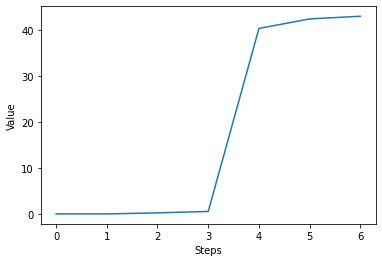

In [196]:
plt.plot(log)
plt.xlabel('Steps')
plt.ylabel('Value')
plt.savefig('31.png', dpi=200)

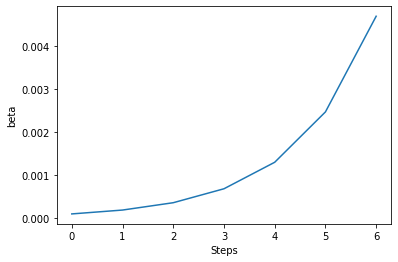

In [197]:
plt.plot(logbeta)
plt.xlabel('Steps')
plt.ylabel('beta')
plt.savefig('32.png', dpi=200)